# Skin disease classification

import

In [4]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import imageio
from torch.optim import lr_scheduler


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, classification_report
import seaborn as sns


# undersampling of class 4 and 5
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from torch.utils.data import DataLoader, Subset
from collections import Counter

import imblearn
import splitfolders
import os
import shutil
from math import ceil
from tqdm import tqdm


In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Preprocessing

In [57]:

transformations1 = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Dataset

In [4]:
train_set_mix = datasets.ImageFolder("Pavani/split_mixed/train", transform=transformations1)
val_set_mix = datasets.ImageFolder("Pavani/split_mixed/val", transform=transformations1)
test_set_mix = datasets.ImageFolder("Pavani/split_mixed/test", transform=transformations1)

train_set_original = datasets.ImageFolder("Pavani/split_original/train", transform=transformations1)
val_set_original = datasets.ImageFolder("Pavani/split_original/val", transform=transformations1)
test_set_original = datasets.ImageFolder("Pavani/split_original/test", transform=transformations1)

train_set_dark = datasets.ImageFolder("Pavani/split_dark/train", transform=transformations1)
val_set_dark = datasets.ImageFolder("Pavani/split_dark/val", transform=transformations1)
test_set_dark = datasets.ImageFolder("Pavani/split_dark/test", transform=transformations1)

### Dataset inspection

In [5]:
print(len(train_set_mix))
print(len(val_set_mix))
print(len(test_set_mix))

12805
4266
4275


Train set distribution:

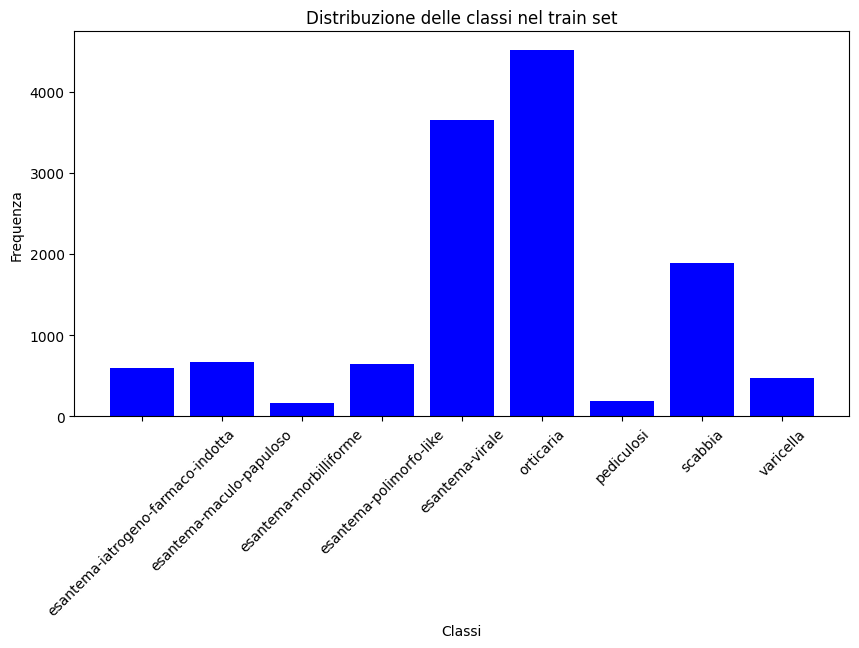

In [6]:
labels = [label for _, label in train_set_mix.samples]
# Count class frequency

label_counts = Counter(labels)


classes = val_set_mix.classes  # classes' names
class_counts = [label_counts[i] for i in range(len(classes))]


plt.figure(figsize=(10, 5))
plt.bar(classes, class_counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Train set classes distribution')
plt.xticks(rotation=45)
plt.show()

In [7]:
class_names  = train_set_mix.classes
class_names

['esantema-iatrogeno-farmaco-indotta',
 'esantema-maculo-papuloso',
 'esantema-morbilliforme',
 'esantema-polimorfo-like',
 'esantema-virale',
 'orticaria',
 'pediculosi',
 'scabbia',
 'varicella']

### Undersampling

Classes to undersample are:
- esantema virale  -> 4
- orticaria -> 5
- scabbia -> 7

In [8]:
def undersample_class(dataset, undersample_classes,split):
  
  labels = [label for _, label in dataset.samples]
  filepaths = [path for path, _ in dataset.samples]
  df = pd.DataFrame({'filepath': filepaths, 'label': labels})

  # Folder to be replaced
  old_folder = 'mix_data_split'
  new_folder = 'original_data_split_under/'+split


  print('Distribuzione originale delle classi:', Counter(df['label'])) # original distribution
  #  RandomUnderSampler
  rus = RandomUnderSampler(sampling_strategy={cls: int(0.15 * Counter(df['label'])[cls]) for cls in undersample_classes}, random_state=42)
  df_res, labels_res = rus.fit_resample(df, df['label'])
  print('Distribuzione delle classi dopo l\'undersampling:', Counter(labels_res)) #  post undersampling distribution

  for i in df_res['filepath'].tolist():
      # Split the path into directory and file name
    directory, file_name = os.path.split(i)
    last_directory = os.path.basename(directory)
    # Replace the old folder with the new folder in the directory path
    new_directory = os.path.join(new_folder,last_directory) #directory.replace(old_folder, new_folder, 1)
    if not os.path.exists(new_directory):
      os.makedirs(new_directory)

    shutil.copy(i, os.path.join(new_directory, file_name))

  return labels_res

In [68]:
train_set_under = datasets.ImageFolder("mix_data_split_under/train", transform=transformations1)
val_set_under = datasets.ImageFolder("mix_data_split_under/val", transform=transformations1)
test_set_under = datasets.ImageFolder("mix_data_split_under/test", transform=transformations1)

In [69]:
train_set_dark_under = datasets.ImageFolder("dark_data_split_under/train", transform=transformations1)
val_set_dark_under = datasets.ImageFolder("dark_data_split_under/val", transform=transformations1)
test_set_dark_under = datasets.ImageFolder("dark_data_split_under/test", transform=transformations1)
train_set_original_under = datasets.ImageFolder("original_data_split_under/train", transform=transformations1)
val_set_original_under = datasets.ImageFolder("original_data_split_under/val", transform=transformations1)
test_set_original_under = datasets.ImageFolder("original_data_split_under/test", transform=transformations1)

In [9]:
print(len(train_set_under))
print(len(test_set_under))
print(len(val_set_under))

4259
1423
1417


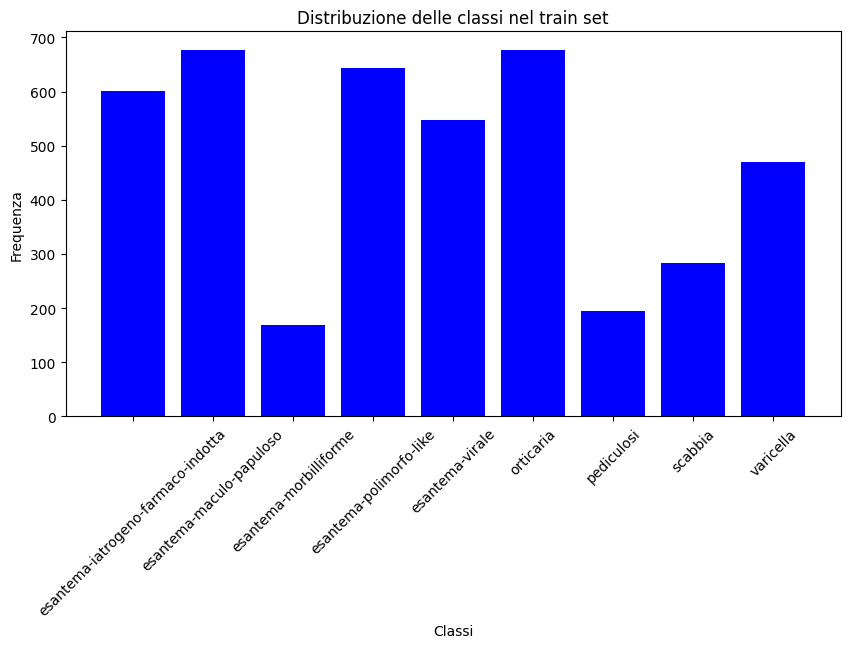

In [13]:
labels = [label for _, label in train_set_under.samples]


label_counts = Counter(labels)


classes = val_set_under.classes  
class_counts = [label_counts[i] for i in range(len(classes))]


plt.figure(figsize=(10, 5))
plt.bar(classes, class_counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Undersampled trainset distribution')
plt.xticks(rotation=45)
plt.show()

Create mixed dataset unblanced


In [35]:
light_skin_path = '/home/guglielmo.biagini/facenet/SkinDesease/original_data_split_under/train'
dark_skin_path = '/home/guglielmo.biagini/facenet/SkinDesease/dark_data_split_under/train'

num_light = np.sum([len(os.listdir(light_skin_path + '/' + folder)) for folder in os.listdir(light_skin_path) if os.path.isdir(os.path.join(light_skin_path, folder))])
num_dark = np.sum([len(os.listdir(dark_skin_path + '/' + folder)) for folder in os.listdir(dark_skin_path) if os.path.isdir(os.path.join(dark_skin_path, folder))])

print(f'Number of light skin images: {num_light}')
print(f'Number of dark skin images: {num_dark}')

Number of light skin images: 2126
Number of dark skin images: 2127


In [38]:
# select different percentages of original and dark image (for example 80% original and 20% dark - balanced dataset)
def create_mixed_dataset(light_skin_path, dark_skin_path, light_percentage, output_path):
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    diseases = os.listdir(light_skin_path)
    num_classes = len(diseases)-1 #ignore ds.store

    for disease in diseases:
        destination_directory = f'{output_path}/{disease}'
        os.makedirs(destination_directory, exist_ok=True)
        light_disease_path = os.path.join(light_skin_path, disease)
        dark_disease_path = os.path.join(dark_skin_path, disease)
        if os.path.isdir(os.path.join(light_skin_path, disease)):
            #compute total number of images in the path
            num_images = len(os.listdir(light_disease_path))
            num_samples_light = ceil(num_images * light_percentage)
            num_samples_dark = ceil(num_images * (1))  #-light_percentage
            sampled_light = os.listdir(light_disease_path)[:num_samples_light]
            sampled_dark = os.listdir(dark_disease_path)[:num_samples_dark]

            #copy the sampled images in the destination folder
            for img in sampled_light:
                shutil.copy(os.path.join(light_disease_path, img), destination_directory)

            for img in sampled_dark:
                shutil.copy(os.path.join(dark_disease_path, img), destination_directory)


create_mixed_dataset(light_skin_path, dark_skin_path, light_percentage=0.5, output_path='balanced_dataset_mixed_80_20')
#create_mixed_dataset(light_skin_path, dark_skin_path, light_percentage=0.5, output_path='path/to/output_50_50')


# Split the data into training, validation and datasets
!rmdir 'balanced_dataset_mixed_80_20/.DS_Store'
path = 'balanced_dataset_mixed_80_20'
print(os.listdir(path))


rmdir: failed to remove 'balanced_dataset_mixed_80_20/.DS_Store': No such file or directory
['esantema-polimorfo-like', 'esantema-morbilliforme', 'orticaria', 'varicella', 'esantema-iatrogeno-farmaco-indotta', 'esantema-maculo-papuloso', 'scabbia', 'esantema-virale', 'pediculosi']


In [81]:
train_set_unbalanced = datasets.ImageFolder("unbalanced_dataset_mixed_100_50", transform=transformations1)
train_loader_unbalanced=torch.utils.data.DataLoader(train_set_unbalanced, batch_size=64, shuffle=True)

### Training

In [70]:
# loader
train_loader_mix = torch.utils.data.DataLoader(train_set_under, batch_size=64, shuffle=True)
val_loader_mix = torch.utils.data.DataLoader(val_set_under, batch_size=64, shuffle=True)
test_loader_mix = torch.utils.data.DataLoader(test_set_under, batch_size=64, shuffle=True)

In [71]:
# for test on original and dark datasets (only test loaders are needed)
train_loader_original = torch.utils.data.DataLoader(train_set_original_under, batch_size=64, shuffle=True)
val_loader_original = torch.utils.data.DataLoader(val_set_original_under, batch_size =64, shuffle=True)
test_loader_original = torch.utils.data.DataLoader(test_set_original_under, batch_size =64, shuffle=True)

train_loader_dark = torch.utils.data.DataLoader(train_set_dark_under, batch_size=64, shuffle=True)
val_loader_dark = torch.utils.data.DataLoader(val_set_dark_under, batch_size =64, shuffle=True)
test_loader_dark = torch.utils.data.DataLoader(test_set_dark_under, batch_size =64, shuffle=True)

In [62]:
# get some random training images
dataiter = iter(train_loader_mix)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.3406973].


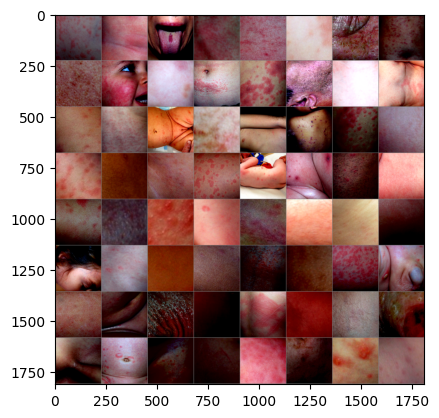

In [63]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(torchvision.utils.make_grid(images))

In [30]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation
    (https://arxiv.org/pdf/1708.02002v2.pdf)
    """

    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = torch.nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [27]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f"Earlystop counter : {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                return True
        return False

### Train on mixed


In [111]:
model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')


for param in model.parameters():
    param.requires_grad = True #Set True to train the whole network
# Creating final fully connected Layer that accorting to the no of classes we require
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 9 ), #len(class_names)
                                 nn.LogSoftmax(dim=1))
model=model.to(device);


In [112]:
# variable learning rate for different layers and using cosine annealing warm restarts
optimizer = optim.SGD([
        {'params': model.conv1.parameters(), 'lr':1e-6},
        {'params': model.layer1.parameters(), 'lr':1e-5},
        {'params': model.layer2.parameters(),'lr':1e-5},
        {'params': model.layer3.parameters(),'lr':1e-4},
        {'params': model.layer4.parameters() ,'lr':1e-4},
        {'params': model.fc.parameters(), 'lr': 1e-2}   # the classifier needs to learn weights faster
    ], lr=0.001, weight_decay=0.0005)

# Restarts the learning rate after every 5 epoch
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0= 5,
        T_mult= 1,
    )
criterion=FocalLoss()

In [74]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

-----starting training--------


67it [02:25,  2.18s/it]


Epoch 1, Training Loss: 1.603695, Validation Loss: 1.543303, Val accuracy: 0.236415


67it [02:25,  2.18s/it]


Epoch 2, Training Loss: 1.491196, Validation Loss: 1.463261, Val accuracy: 0.302047


67it [02:25,  2.18s/it]


Epoch 3, Training Loss: 1.418445, Validation Loss: 1.413755, Val accuracy: 0.333098


67it [02:31,  2.26s/it]


Epoch 4, Training Loss: 1.378415, Validation Loss: 1.393124, Val accuracy: 0.342272


67it [02:37,  2.34s/it]


Epoch 5, Training Loss: 1.365303, Validation Loss: 1.390118, Val accuracy: 0.346507


67it [02:36,  2.34s/it]


Epoch 6, Training Loss: 1.336383, Validation Loss: 1.320239, Val accuracy: 0.340861


67it [02:36,  2.33s/it]


Epoch 7, Training Loss: 1.259540, Validation Loss: 1.257210, Val accuracy: 0.384615


67it [02:37,  2.34s/it]


Epoch 8, Training Loss: 1.199333, Validation Loss: 1.225751, Val accuracy: 0.374735


67it [02:36,  2.33s/it]


Epoch 9, Training Loss: 1.169826, Validation Loss: 1.208688, Val accuracy: 0.384615


67it [02:35,  2.33s/it]


Epoch 10, Training Loss: 1.155544, Validation Loss: 1.206277, Val accuracy: 0.388850


67it [02:36,  2.34s/it]


Epoch 11, Training Loss: 1.147684, Validation Loss: 1.165095, Val accuracy: 0.390967


67it [02:36,  2.34s/it]


Epoch 12, Training Loss: 1.097006, Validation Loss: 1.132625, Val accuracy: 0.396613


67it [02:36,  2.33s/it]


Epoch 13, Training Loss: 1.048624, Validation Loss: 1.109567, Val accuracy: 0.404375


67it [02:35,  2.33s/it]


Epoch 14, Training Loss: 1.021329, Validation Loss: 1.091310, Val accuracy: 0.412138


67it [02:36,  2.33s/it]


Epoch 15, Training Loss: 1.019573, Validation Loss: 1.093751, Val accuracy: 0.404375


67it [02:36,  2.34s/it]


Epoch 16, Training Loss: 1.028522, Validation Loss: 1.064106, Val accuracy: 0.423430


67it [02:35,  2.33s/it]


Epoch 17, Training Loss: 0.984452, Validation Loss: 1.041657, Val accuracy: 0.418490


67it [02:36,  2.33s/it]


Epoch 18, Training Loss: 0.952880, Validation Loss: 1.027396, Val accuracy: 0.429781


67it [02:36,  2.34s/it]


Epoch 19, Training Loss: 0.932275, Validation Loss: 1.019693, Val accuracy: 0.426958


67it [02:36,  2.33s/it]


Epoch 20, Training Loss: 0.924988, Validation Loss: 1.023664, Val accuracy: 0.429781


67it [02:37,  2.35s/it]


Epoch 21, Training Loss: 0.930478, Validation Loss: 1.001353, Val accuracy: 0.440367


67it [02:36,  2.33s/it]


Epoch 22, Training Loss: 0.902314, Validation Loss: 0.997144, Val accuracy: 0.434016


67it [02:36,  2.33s/it]


Epoch 23, Training Loss: 0.879501, Validation Loss: 0.976104, Val accuracy: 0.453070


67it [02:36,  2.33s/it]


Epoch 24, Training Loss: 0.847400, Validation Loss: 0.957696, Val accuracy: 0.449541


67it [02:36,  2.33s/it]


Epoch 25, Training Loss: 0.845762, Validation Loss: 0.971898, Val accuracy: 0.452364


67it [02:36,  2.33s/it]


Epoch 26, Training Loss: 0.856335, Validation Loss: 0.962545, Val accuracy: 0.441778


67it [02:36,  2.33s/it]


Epoch 27, Training Loss: 0.837318, Validation Loss: 0.950393, Val accuracy: 0.453776


67it [02:36,  2.33s/it]


Epoch 28, Training Loss: 0.820253, Validation Loss: 0.929190, Val accuracy: 0.466478


67it [02:36,  2.34s/it]


Epoch 29, Training Loss: 0.795248, Validation Loss: 0.929076, Val accuracy: 0.458716


67it [02:36,  2.33s/it]


Epoch 30, Training Loss: 0.788520, Validation Loss: 0.921535, Val accuracy: 0.464361


67it [02:35,  2.33s/it]


Epoch 31, Training Loss: 0.797357, Validation Loss: 0.916777, Val accuracy: 0.464361


67it [02:35,  2.33s/it]


Epoch 32, Training Loss: 0.781867, Validation Loss: 0.914985, Val accuracy: 0.468596


67it [02:36,  2.33s/it]


Epoch 33, Training Loss: 0.744037, Validation Loss: 0.909944, Val accuracy: 0.467184


67it [02:36,  2.33s/it]


Epoch 34, Training Loss: 0.744510, Validation Loss: 0.888522, Val accuracy: 0.460833


67it [02:36,  2.34s/it]


Epoch 35, Training Loss: 0.733074, Validation Loss: 0.884921, Val accuracy: 0.475653


67it [02:35,  2.32s/it]


Epoch 36, Training Loss: 0.756620, Validation Loss: 0.902686, Val accuracy: 0.455893


67it [02:30,  2.24s/it]


Epoch 37, Training Loss: 0.729603, Validation Loss: 0.873493, Val accuracy: 0.467184


67it [02:25,  2.17s/it]


Epoch 38, Training Loss: 0.711261, Validation Loss: 0.863906, Val accuracy: 0.483416


67it [02:26,  2.18s/it]


Epoch 39, Training Loss: 0.701354, Validation Loss: 0.866941, Val accuracy: 0.486239


67it [02:25,  2.18s/it]


Epoch 40, Training Loss: 0.684150, Validation Loss: 0.873512, Val accuracy: 0.474947


67it [02:27,  2.19s/it]


Epoch 41, Training Loss: 0.704307, Validation Loss: 0.866137, Val accuracy: 0.475653


67it [02:26,  2.18s/it]


Epoch 42, Training Loss: 0.683077, Validation Loss: 0.844960, Val accuracy: 0.477770


67it [02:24,  2.16s/it]


Epoch 43, Training Loss: 0.670912, Validation Loss: 0.853322, Val accuracy: 0.479887


67it [02:25,  2.18s/it]


Epoch 44, Training Loss: 0.646961, Validation Loss: 0.849304, Val accuracy: 0.486239


67it [02:25,  2.17s/it]


Epoch 45, Training Loss: 0.646809, Validation Loss: 0.842607, Val accuracy: 0.491179


67it [02:25,  2.17s/it]


Epoch 46, Training Loss: 0.669524, Validation Loss: 0.843269, Val accuracy: 0.464361


67it [02:25,  2.17s/it]


Epoch 47, Training Loss: 0.642871, Validation Loss: 0.852907, Val accuracy: 0.476359


67it [02:25,  2.17s/it]


Epoch 48, Training Loss: 0.633169, Validation Loss: 0.835469, Val accuracy: 0.484121


67it [02:26,  2.18s/it]


Epoch 49, Training Loss: 0.616724, Validation Loss: 0.821287, Val accuracy: 0.488356


67it [02:34,  2.30s/it]


Epoch 50, Training Loss: 0.607303, Validation Loss: 0.820919, Val accuracy: 0.494707


67it [02:54,  2.60s/it]


Epoch 51, Training Loss: 0.634557, Validation Loss: 0.844688, Val accuracy: 0.492590


67it [02:28,  2.21s/it]


Epoch 52, Training Loss: 0.595673, Validation Loss: 0.813594, Val accuracy: 0.508821


67it [02:35,  2.32s/it]


Epoch 53, Training Loss: 0.583116, Validation Loss: 0.809212, Val accuracy: 0.491884


67it [02:37,  2.35s/it]


Epoch 54, Training Loss: 0.575837, Validation Loss: 0.805014, Val accuracy: 0.498941


67it [02:36,  2.34s/it]


Epoch 55, Training Loss: 0.568521, Validation Loss: 0.813952, Val accuracy: 0.498941


67it [03:46,  3.37s/it]


Epoch 56, Training Loss: 0.570753, Validation Loss: 0.808561, Val accuracy: 0.505999


67it [03:05,  2.78s/it]


Epoch 57, Training Loss: 0.567677, Validation Loss: 0.797619, Val accuracy: 0.505293


67it [02:38,  2.37s/it]


Epoch 58, Training Loss: 0.547695, Validation Loss: 0.805873, Val accuracy: 0.494707


67it [02:40,  2.40s/it]


Epoch 59, Training Loss: 0.550282, Validation Loss: 0.788590, Val accuracy: 0.502470


67it [02:42,  2.42s/it]


Epoch 60, Training Loss: 0.542577, Validation Loss: 0.774768, Val accuracy: 0.511644


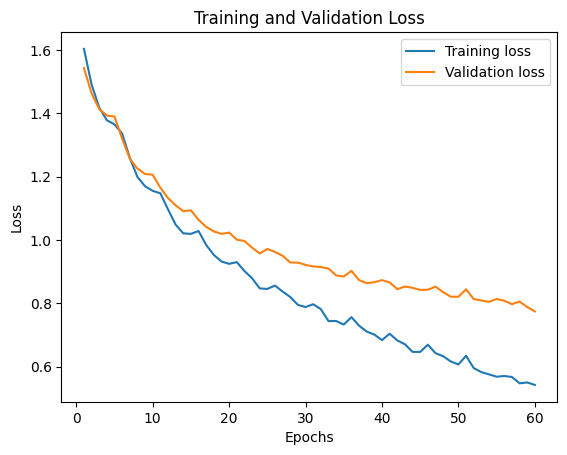

In [113]:
early_stopper = EarlyStopper(patience=5, min_delta=10) 
epochs = 60
best_acc = 0.0
iters = len(train_loader_mix)
patience = 5
best_val_loss = np.Inf

train_loss, val_loss = [], []
print("-----starting training--------")
for epoch in range (epochs):

    train_loss_epoch = 0.0
    valid_loss_epoch = 0.0
    accuracy = 0.0

    # Trainin_the_ model
    model.train()

    for i, sample in tqdm(enumerate(train_loader_mix)):
        inputs, labels = sample
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear Optimizers
        optimizer.zero_grad()
        # Forward Pass
        logps = model.forward(inputs)
        # Loss

        loss = criterion(logps, labels)
        # Backprop (Calculate Gradients)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        scheduler.step(epoch + i / iters) # if using cosine annealing warm restarts
        # Add the loss to the  running loss
        train_loss_epoch += loss.item() * inputs.size(0)
    #accuracy_train = correct_predictions / total_samples
        torch.cuda.empty_cache()

    # Update the learning rate scheduler
    #scheduler.step()

    # Validation
    model.eval ()
    correct_predictions = 0
    total_samples = 0
    # Tell torch not to calculate gradients
    with torch.no_grad ():
        for inputs, labels in val_loader_mix:
            # Move to device
            inputs, labels = inputs.to (device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            val_loss_batch = criterion(output, labels)
            # Add loss to the validation set's running loss
            valid_loss_epoch += val_loss_batch.item() * inputs.size(0)

            # Since our model outputs a LogSoftmax, find the real
            _, predicted = torch.max(output, 1)

            correct_predictions += torch.sum(predicted == labels).item()
            total_samples += labels.size(0)
        accuracy = correct_predictions / total_samples

    # if early_stopper.early_stop(valid_loss_epoch):
    #     print(f'Early stopping on epoch {epoch + 1}')
    #     break




    # Get the average loss for the  epoch
    train_loss_epoch /= len(train_loader_mix.dataset)
    valid_loss_epoch /= len(val_loader_mix.dataset)

    # Append the loss and accuracy
    train_loss.append(train_loss_epoch)
    val_loss.append(valid_loss_epoch)

    # Print out the information
    print(f'Epoch {epoch + 1},'
          f' Training Loss: {train_loss_epoch:.6f},'
          f' Validation Loss: {valid_loss_epoch:.6f},'
          f' Val accuracy: {accuracy:.6f}'
          #f' Train accuracy: {accuracy_train:.6f}'
    )
    if early_stopper.early_stop(valid_loss_epoch):
        print("Patience limit reached, stopping the training")
        break
        


# Plotting the training and validation loss
plt.plot(range(1, epochs+1), train_loss, label='Training loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#print(f'Best Validation Accuracy: {best_acc:.6f}')

In [114]:
torch.save(model.state_dict(), 'weights_unfreeze.pth') # save weights

### Train on Dark

In [105]:
model2 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

#Using the pretrained model we Dont Train the initial layers.
for param in model2.parameters():
    param.requires_grad = True #Set True to train the whole network
# Creating final fully connected Layer that accorting to the no of classes we require
model2.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 9 ), #len(class_names)
                                 nn.LogSoftmax(dim=1))
model2=model2.to(device)


In [106]:
# variable learning rate for different layers and using cosine annealing warm restarts
optimizer = optim.SGD([
        {'params': model2.conv1.parameters(), 'lr':1e-6},
        {'params': model2.layer1.parameters(), 'lr':1e-5},
        {'params': model2.layer2.parameters(),'lr':1e-5},
        {'params': model2.layer3.parameters(),'lr':1e-4},
        {'params': model2.layer4.parameters() ,'lr':1e-4},
        {'params': model2.fc.parameters(), 'lr': 1e-2}   # the classifier needs to learn weights faster
    ], lr=0.001, weight_decay=0.0005)

# Restarts the learning rate after every 5 epoch
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0= 5,
        T_mult= 1,
    )
criterion=FocalLoss()

-----starting training--------


34it [00:39,  1.17s/it]


Epoch 1, Training Loss: 1.637233, Validation Loss: 1.594011, Val accuracy: 0.190948


34it [00:38,  1.14s/it]


Epoch 2, Training Loss: 1.567009, Validation Loss: 1.553706, Val accuracy: 0.265912


34it [00:38,  1.14s/it]


Epoch 3, Training Loss: 1.524386, Validation Loss: 1.522858, Val accuracy: 0.301273


34it [00:38,  1.14s/it]


Epoch 4, Training Loss: 1.497269, Validation Loss: 1.507689, Val accuracy: 0.285714


34it [00:41,  1.21s/it]


Epoch 5, Training Loss: 1.483480, Validation Loss: 1.502152, Val accuracy: 0.299859


34it [00:38,  1.14s/it]


Epoch 6, Training Loss: 1.469360, Validation Loss: 1.484152, Val accuracy: 0.239038


34it [00:38,  1.13s/it]


Epoch 7, Training Loss: 1.429856, Validation Loss: 1.433920, Val accuracy: 0.304102


34it [00:38,  1.14s/it]


Epoch 8, Training Loss: 1.387821, Validation Loss: 1.398877, Val accuracy: 0.332390


34it [00:38,  1.14s/it]


Epoch 9, Training Loss: 1.353710, Validation Loss: 1.382356, Val accuracy: 0.333805


34it [00:38,  1.14s/it]


Epoch 10, Training Loss: 1.347212, Validation Loss: 1.383921, Val accuracy: 0.338048


34it [00:39,  1.17s/it]


Epoch 11, Training Loss: 1.325671, Validation Loss: 1.361252, Val accuracy: 0.335219


34it [00:39,  1.16s/it]


Epoch 12, Training Loss: 1.300593, Validation Loss: 1.322833, Val accuracy: 0.333805


34it [00:38,  1.14s/it]


Epoch 13, Training Loss: 1.259427, Validation Loss: 1.296039, Val accuracy: 0.321075


34it [00:38,  1.14s/it]


Epoch 14, Training Loss: 1.231745, Validation Loss: 1.281709, Val accuracy: 0.360679


34it [00:38,  1.14s/it]


Epoch 15, Training Loss: 1.230120, Validation Loss: 1.277775, Val accuracy: 0.346535


34it [00:38,  1.13s/it]


Epoch 16, Training Loss: 1.219635, Validation Loss: 1.257478, Val accuracy: 0.345120


34it [00:38,  1.13s/it]


Epoch 17, Training Loss: 1.184422, Validation Loss: 1.233678, Val accuracy: 0.353607


34it [00:38,  1.14s/it]


Epoch 18, Training Loss: 1.151307, Validation Loss: 1.226113, Val accuracy: 0.364922


34it [00:38,  1.13s/it]


Epoch 19, Training Loss: 1.140170, Validation Loss: 1.208654, Val accuracy: 0.371994


34it [00:38,  1.14s/it]


Epoch 20, Training Loss: 1.116597, Validation Loss: 1.203915, Val accuracy: 0.369165


34it [00:38,  1.14s/it]


Epoch 21, Training Loss: 1.126615, Validation Loss: 1.279470, Val accuracy: 0.298444


34it [00:38,  1.14s/it]


Epoch 22, Training Loss: 1.100972, Validation Loss: 1.205399, Val accuracy: 0.362093


34it [00:38,  1.14s/it]


Epoch 23, Training Loss: 1.069747, Validation Loss: 1.149178, Val accuracy: 0.379066


34it [00:38,  1.14s/it]


Epoch 24, Training Loss: 1.052856, Validation Loss: 1.147811, Val accuracy: 0.373409


34it [00:38,  1.13s/it]


Epoch 25, Training Loss: 1.044173, Validation Loss: 1.141119, Val accuracy: 0.393211


34it [00:38,  1.13s/it]


Epoch 26, Training Loss: 1.051294, Validation Loss: 1.150225, Val accuracy: 0.352192


34it [00:38,  1.13s/it]


Epoch 27, Training Loss: 1.014946, Validation Loss: 1.140562, Val accuracy: 0.357850


34it [00:38,  1.14s/it]


Epoch 28, Training Loss: 1.006843, Validation Loss: 1.117997, Val accuracy: 0.410184


34it [00:38,  1.14s/it]


Epoch 29, Training Loss: 0.983501, Validation Loss: 1.100882, Val accuracy: 0.391796


34it [00:38,  1.14s/it]


Epoch 30, Training Loss: 0.972718, Validation Loss: 1.104601, Val accuracy: 0.383310


34it [00:38,  1.14s/it]


Epoch 31, Training Loss: 0.976950, Validation Loss: 1.109990, Val accuracy: 0.393211


34it [00:38,  1.14s/it]


Epoch 32, Training Loss: 0.970930, Validation Loss: 1.132907, Val accuracy: 0.384724


34it [00:38,  1.13s/it]


Epoch 33, Training Loss: 0.953800, Validation Loss: 1.065615, Val accuracy: 0.396040


34it [00:38,  1.14s/it]


Epoch 34, Training Loss: 0.924401, Validation Loss: 1.080156, Val accuracy: 0.393211


34it [00:38,  1.13s/it]


Epoch 35, Training Loss: 0.911331, Validation Loss: 1.074401, Val accuracy: 0.404526


34it [00:38,  1.13s/it]


Epoch 36, Training Loss: 0.921576, Validation Loss: 1.146338, Val accuracy: 0.360679


34it [00:38,  1.13s/it]


Epoch 37, Training Loss: 0.902454, Validation Loss: 1.123935, Val accuracy: 0.374823


34it [00:38,  1.13s/it]


Epoch 38, Training Loss: 0.904466, Validation Loss: 1.108301, Val accuracy: 0.394625


34it [00:38,  1.14s/it]


Epoch 39, Training Loss: 0.870689, Validation Loss: 1.043451, Val accuracy: 0.407355


34it [00:38,  1.14s/it]


Epoch 40, Training Loss: 0.868947, Validation Loss: 1.045124, Val accuracy: 0.393211


34it [00:38,  1.13s/it]


Epoch 41, Training Loss: 0.877722, Validation Loss: 1.084462, Val accuracy: 0.410184


34it [00:38,  1.13s/it]


Epoch 42, Training Loss: 0.842938, Validation Loss: 1.047973, Val accuracy: 0.408769


34it [00:38,  1.13s/it]


Epoch 43, Training Loss: 0.835023, Validation Loss: 1.040516, Val accuracy: 0.400283


34it [00:38,  1.14s/it]


Epoch 44, Training Loss: 0.817442, Validation Loss: 1.048784, Val accuracy: 0.405941


34it [00:39,  1.15s/it]


Epoch 45, Training Loss: 0.810313, Validation Loss: 1.025673, Val accuracy: 0.407355


34it [00:38,  1.14s/it]


Epoch 46, Training Loss: 0.820730, Validation Loss: 1.155435, Val accuracy: 0.376238


34it [00:38,  1.15s/it]


Epoch 47, Training Loss: 0.806581, Validation Loss: 1.050087, Val accuracy: 0.405941


34it [00:38,  1.14s/it]


Epoch 48, Training Loss: 0.783308, Validation Loss: 1.031818, Val accuracy: 0.417256


34it [00:38,  1.14s/it]


Epoch 49, Training Loss: 0.771604, Validation Loss: 1.017133, Val accuracy: 0.421499


34it [00:38,  1.14s/it]


Epoch 50, Training Loss: 0.775340, Validation Loss: 1.018596, Val accuracy: 0.415842


34it [00:38,  1.13s/it]


Epoch 51, Training Loss: 0.775090, Validation Loss: 1.043535, Val accuracy: 0.405941


34it [00:38,  1.15s/it]


Epoch 52, Training Loss: 0.776234, Validation Loss: 0.995798, Val accuracy: 0.420085


34it [00:38,  1.14s/it]


Epoch 53, Training Loss: 0.756757, Validation Loss: 1.039833, Val accuracy: 0.413013


34it [00:38,  1.14s/it]


Epoch 54, Training Loss: 0.750845, Validation Loss: 1.008476, Val accuracy: 0.442716


34it [00:38,  1.15s/it]


Epoch 55, Training Loss: 0.732975, Validation Loss: 1.022958, Val accuracy: 0.404526


34it [00:38,  1.14s/it]


Epoch 56, Training Loss: 0.745621, Validation Loss: 1.073096, Val accuracy: 0.417256


34it [00:38,  1.13s/it]


Epoch 57, Training Loss: 0.750638, Validation Loss: 1.125029, Val accuracy: 0.376238


34it [00:38,  1.14s/it]


Epoch 58, Training Loss: 0.708449, Validation Loss: 1.015512, Val accuracy: 0.407355


34it [00:38,  1.15s/it]


Epoch 59, Training Loss: 0.703534, Validation Loss: 0.986284, Val accuracy: 0.432815


34it [00:38,  1.14s/it]


Epoch 60, Training Loss: 0.707725, Validation Loss: 1.007913, Val accuracy: 0.408769


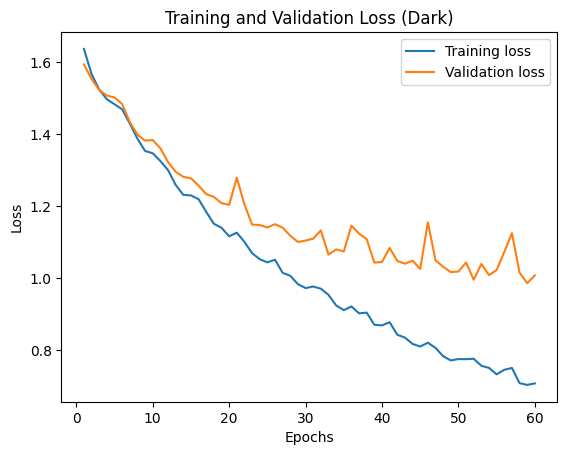

In [107]:
early_stopper = EarlyStopper(patience=5, min_delta=10) 
epochs = 60
best_acc = 0.0
iters = len(train_loader_mix)
patience = 5
best_val_loss = np.Inf

train_loss, val_loss = [], []
print("-----starting training--------")
for epoch in range (epochs):

    train_loss_epoch = 0.0
    valid_loss_epoch = 0.0
    accuracy = 0.0

    # Trainin_the_ model
    model2.train()

    for i, sample in tqdm(enumerate (train_loader_dark)):
        inputs, labels = sample
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear Optimizers
        optimizer.zero_grad()
        # Forward Pass
        logps = model2.forward(inputs)
        # Loss

        loss = criterion(logps, labels)
        # Backprop (Calculate Gradients)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        scheduler.step(epoch + i / iters) # if using cosine annealing warm restarts
        # Add the loss to the  running loss
        train_loss_epoch += loss.item() * inputs.size(0)
    #accuracy_train = correct_predictions / total_samples

    # Update the learning rate scheduler
    #scheduler.step()

    # Validation
    model2.eval ()
    correct_predictions = 0
    total_samples = 0
    # Tell torch not to calculate gradients
    with torch.no_grad ():
        for inputs, labels in val_loader_dark:
            # Move to device
            inputs, labels = inputs.to (device), labels.to(device)
            # Forward pass
            output = model2.forward(inputs)
            # Calculate Loss
            val_loss_batch = criterion(output, labels)
            # Add loss to the validation set's running loss
            valid_loss_epoch += val_loss_batch.item() * inputs.size(0)

            # Since our model outputs a LogSoftmax, find the real
            _, predicted = torch.max(output, 1)

            correct_predictions += torch.sum(predicted == labels).item()
            total_samples += labels.size(0)
        accuracy = correct_predictions / total_samples

    # if early_stopper.early_stop(valid_loss_epoch):
    #     print(f'Early stopping on epoch {epoch + 1}')
    #     break




    # Get the average loss for the  epoch
    train_loss_epoch /= len(train_loader_dark.dataset)
    valid_loss_epoch /= len(val_loader_dark.dataset)

    # Append the loss and accuracy
    train_loss.append(train_loss_epoch)
    val_loss.append(valid_loss_epoch)

    # Print out the information
    print(f'Epoch {epoch + 1},'
          f' Training Loss: {train_loss_epoch:.6f},'
          f' Validation Loss: {valid_loss_epoch:.6f},'
          f' Val accuracy: {accuracy:.6f}'
          #f' Train accuracy: {accuracy_train:.6f}'
    )
    if early_stopper.early_stop(valid_loss_epoch):
        print("Patience limit reached, stopping the training")
        break


# Plotting the training and validation loss
plt.plot(range(1, epochs+1), train_loss, label='Training loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Dark)')
plt.legend()
plt.show()

#print(f'Best Validation Accuracy: {best_acc:.6f}')

In [118]:
torch.save(model2.state_dict(), 'dark_augmentation_unfreeze.pth') # save weights

### Train on unbalanced

In [ ]:
model3 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

#Using the pretrained model we Dont Train the initial layers.
for param in model3.parameters():
    param.requires_grad = True #Set True to train the whole network
# Creating final fully connected Layer that accorting to the no of classes we require
model3.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 9 ), #len(class_names)
                                 nn.LogSoftmax(dim=1))
model3=model3.to(device)
# Loss and optimizer
criterion = FocalLoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights) # uncomment for training with weighting


# variable learning rate for different layers and using cosine annealing warm restarts
optimizer = optim.SGD([
        {'params': model3.conv1.parameters(), 'lr':1e-6},
        {'params': model3.layer1.parameters(), 'lr':1e-5},
        {'params': model3.layer2.parameters(),'lr':1e-5},
        {'params': model3.layer3.parameters(),'lr':1e-4},
        {'params': model3.layer4.parameters() ,'lr':1e-4},
        {'params': model3.fc.parameters(), 'lr': 1e-2}   # the classifier needs to learn weights faster
    ], lr=0.001, weight_decay=0.0005)

# Restarts the learning rate after every 5 epoch
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0= 5,
        T_mult= 1,
    )

-----starting training--------


50it [01:39,  1.99s/it]


Epoch 1, Training Loss: 1.618948, Validation Loss: 1.562277, Val accuracy: 0.227723


50it [01:38,  1.97s/it]


Epoch 2, Training Loss: 1.522952, Validation Loss: 1.499863, Val accuracy: 0.292786


50it [01:37,  1.95s/it]


Epoch 3, Training Loss: 1.466027, Validation Loss: 1.453922, Val accuracy: 0.301273


50it [01:37,  1.95s/it]


Epoch 4, Training Loss: 1.432660, Validation Loss: 1.436201, Val accuracy: 0.311174


50it [01:37,  1.94s/it]


Epoch 5, Training Loss: 1.416239, Validation Loss: 1.435364, Val accuracy: 0.306931


50it [01:37,  1.95s/it]


Epoch 6, Training Loss: 1.383322, Validation Loss: 1.371961, Val accuracy: 0.336634


50it [01:36,  1.94s/it]


Epoch 7, Training Loss: 1.311788, Validation Loss: 1.310022, Val accuracy: 0.369165


50it [01:37,  1.95s/it]


Epoch 8, Training Loss: 1.251698, Validation Loss: 1.273502, Val accuracy: 0.350778


50it [01:37,  1.94s/it]


Epoch 9, Training Loss: 1.231156, Validation Loss: 1.257898, Val accuracy: 0.364922


50it [01:37,  1.95s/it]


Epoch 10, Training Loss: 1.215697, Validation Loss: 1.258343, Val accuracy: 0.360679


50it [01:36,  1.94s/it]


Epoch 11, Training Loss: 1.206150, Validation Loss: 1.222760, Val accuracy: 0.355021


50it [01:36,  1.93s/it]


Epoch 12, Training Loss: 1.166232, Validation Loss: 1.186866, Val accuracy: 0.377652


50it [01:36,  1.94s/it]


Epoch 13, Training Loss: 1.116636, Validation Loss: 1.171968, Val accuracy: 0.373409


50it [01:37,  1.94s/it]


Epoch 14, Training Loss: 1.087904, Validation Loss: 1.155880, Val accuracy: 0.390382


50it [01:37,  1.94s/it]


Epoch 15, Training Loss: 1.068356, Validation Loss: 1.152689, Val accuracy: 0.380481


50it [01:37,  1.95s/it]


Epoch 16, Training Loss: 1.083258, Validation Loss: 1.141303, Val accuracy: 0.379066


50it [01:37,  1.95s/it]


Epoch 17, Training Loss: 1.045722, Validation Loss: 1.108715, Val accuracy: 0.391796


50it [01:36,  1.93s/it]


Epoch 18, Training Loss: 1.005767, Validation Loss: 1.092314, Val accuracy: 0.400283


50it [01:37,  1.94s/it]


Epoch 19, Training Loss: 0.987011, Validation Loss: 1.092434, Val accuracy: 0.393211


50it [01:36,  1.93s/it]


Epoch 20, Training Loss: 0.983176, Validation Loss: 1.070394, Val accuracy: 0.401697


50it [01:37,  1.95s/it]


Epoch 21, Training Loss: 0.981746, Validation Loss: 1.096875, Val accuracy: 0.374823


50it [01:37,  1.94s/it]


Epoch 22, Training Loss: 0.951692, Validation Loss: 1.052569, Val accuracy: 0.401697


50it [01:37,  1.95s/it]


Epoch 23, Training Loss: 0.935203, Validation Loss: 1.059799, Val accuracy: 0.388967


50it [01:37,  1.95s/it]


Epoch 24, Training Loss: 0.908791, Validation Loss: 1.027079, Val accuracy: 0.398868


50it [01:37,  1.95s/it]


Epoch 25, Training Loss: 0.898439, Validation Loss: 1.040153, Val accuracy: 0.413013


50it [01:37,  1.95s/it]


Epoch 26, Training Loss: 0.917874, Validation Loss: 1.046556, Val accuracy: 0.401697


50it [01:37,  1.95s/it]


Epoch 27, Training Loss: 0.885335, Validation Loss: 1.018362, Val accuracy: 0.422914


50it [01:37,  1.95s/it]


Epoch 28, Training Loss: 0.866740, Validation Loss: 1.013001, Val accuracy: 0.405941


50it [01:37,  1.94s/it]


Epoch 29, Training Loss: 0.850979, Validation Loss: 0.999513, Val accuracy: 0.425743


50it [01:37,  1.95s/it]


Epoch 30, Training Loss: 0.839470, Validation Loss: 0.998832, Val accuracy: 0.424328


50it [01:36,  1.94s/it]


Epoch 31, Training Loss: 0.853490, Validation Loss: 1.011291, Val accuracy: 0.421499


50it [01:37,  1.95s/it]


Epoch 32, Training Loss: 0.812803, Validation Loss: 0.993054, Val accuracy: 0.432815


50it [01:36,  1.93s/it]


Epoch 33, Training Loss: 0.803049, Validation Loss: 0.982442, Val accuracy: 0.431400


50it [01:36,  1.94s/it]


Epoch 34, Training Loss: 0.786875, Validation Loss: 0.991727, Val accuracy: 0.418670


50it [01:36,  1.94s/it]


Epoch 35, Training Loss: 0.783244, Validation Loss: 0.966670, Val accuracy: 0.420085


50it [01:37,  1.95s/it]


Epoch 36, Training Loss: 0.802010, Validation Loss: 0.960052, Val accuracy: 0.427157


50it [01:36,  1.94s/it]


Epoch 37, Training Loss: 0.774457, Validation Loss: 0.979033, Val accuracy: 0.425743


50it [01:37,  1.95s/it]


Epoch 38, Training Loss: 0.756247, Validation Loss: 0.956318, Val accuracy: 0.442716


50it [01:36,  1.94s/it]


Epoch 39, Training Loss: 0.742403, Validation Loss: 0.961463, Val accuracy: 0.428571


50it [01:37,  1.94s/it]


Epoch 40, Training Loss: 0.735598, Validation Loss: 0.946906, Val accuracy: 0.432815


50it [01:37,  1.94s/it]


Epoch 41, Training Loss: 0.765833, Validation Loss: 0.956757, Val accuracy: 0.455446


50it [01:37,  1.94s/it]


Epoch 42, Training Loss: 0.737397, Validation Loss: 0.976152, Val accuracy: 0.427157


50it [01:37,  1.94s/it]


Epoch 43, Training Loss: 0.721400, Validation Loss: 0.938933, Val accuracy: 0.431400


50it [01:36,  1.93s/it]


Epoch 44, Training Loss: 0.704421, Validation Loss: 0.941816, Val accuracy: 0.449788


50it [01:37,  1.95s/it]


Epoch 45, Training Loss: 0.689786, Validation Loss: 0.936858, Val accuracy: 0.444130


50it [01:37,  1.94s/it]


Epoch 46, Training Loss: 0.699603, Validation Loss: 0.945486, Val accuracy: 0.441301


50it [01:37,  1.95s/it]


Epoch 47, Training Loss: 0.691125, Validation Loss: 0.915305, Val accuracy: 0.462518


50it [01:36,  1.94s/it]


Epoch 48, Training Loss: 0.682717, Validation Loss: 0.936707, Val accuracy: 0.441301


50it [01:37,  1.95s/it]


Epoch 49, Training Loss: 0.657413, Validation Loss: 0.929768, Val accuracy: 0.459689


50it [01:36,  1.94s/it]


Epoch 50, Training Loss: 0.640459, Validation Loss: 0.918609, Val accuracy: 0.445545


50it [01:37,  1.95s/it]


Epoch 51, Training Loss: 0.676929, Validation Loss: 0.935997, Val accuracy: 0.439887


50it [01:37,  1.94s/it]


Epoch 52, Training Loss: 0.641840, Validation Loss: 0.923217, Val accuracy: 0.448373


50it [01:37,  1.94s/it]


Epoch 53, Training Loss: 0.642901, Validation Loss: 0.909576, Val accuracy: 0.458274


50it [01:37,  1.94s/it]


Epoch 54, Training Loss: 0.623383, Validation Loss: 0.915828, Val accuracy: 0.461103


50it [01:37,  1.94s/it]


Epoch 55, Training Loss: 0.615481, Validation Loss: 0.916411, Val accuracy: 0.435644


50it [01:37,  1.94s/it]


Epoch 56, Training Loss: 0.627743, Validation Loss: 0.925587, Val accuracy: 0.458274


50it [01:36,  1.93s/it]


Epoch 57, Training Loss: 0.614851, Validation Loss: 0.914353, Val accuracy: 0.461103


50it [01:37,  1.95s/it]


Epoch 58, Training Loss: 0.600863, Validation Loss: 0.925281, Val accuracy: 0.446959


50it [01:36,  1.93s/it]


Epoch 59, Training Loss: 0.584639, Validation Loss: 0.917602, Val accuracy: 0.452617


50it [01:36,  1.94s/it]


Epoch 60, Training Loss: 0.581291, Validation Loss: 0.898758, Val accuracy: 0.465347


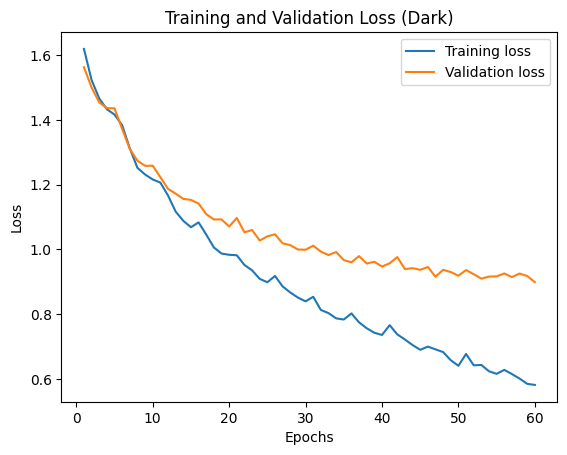

In [ ]:
early_stopper = EarlyStopper(patience=5, min_delta=10) 
epochs = 60
best_acc = 0.0
iters = len(train_loader_mix)
patience = 5
best_val_loss = np.Inf

train_loss, val_loss = [], []
print("-----starting training--------")
for epoch in range (epochs):

    train_loss_epoch = 0.0
    valid_loss_epoch = 0.0
    accuracy = 0.0

    # Trainin_the_ model
    model3.train()

    for i, sample in tqdm(enumerate (train_loader_unbalanced)):
        inputs, labels = sample
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear Optimizers
        optimizer.zero_grad()
        # Forward Pass
        logps = model3.forward(inputs)
        # Loss

        loss = criterion(logps, labels)
        # Backprop (Calculate Gradients)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        scheduler.step(epoch + i / iters) # if using cosine annealing warm restarts
        # Add the loss to the  running loss
        train_loss_epoch += loss.item() * inputs.size(0)
    #accuracy_train = correct_predictions / total_samples

    # Update the learning rate scheduler
    #scheduler.step()

    # Validation
    model3.eval ()
    correct_predictions = 0
    total_samples = 0
    # Tell torch not to calculate gradients
    with torch.no_grad ():
        for inputs, labels in val_loader_dark:
            # Move to device
            inputs, labels = inputs.to (device), labels.to(device)
            # Forward pass
            output = model3.forward(inputs)
            # Calculate Loss
            val_loss_batch = criterion(output, labels)
            # Add loss to the validation set's running loss
            valid_loss_epoch += val_loss_batch.item() * inputs.size(0)

            # Since our model outputs a LogSoftmax, find the real
            _, predicted = torch.max(output, 1)

            correct_predictions += torch.sum(predicted == labels).item()
            total_samples += labels.size(0)
        accuracy = correct_predictions / total_samples

    # if early_stopper.early_stop(valid_loss_epoch):
    #     print(f'Early stopping on epoch {epoch + 1}')
    #     break




    # Get the average loss for the  epoch
    train_loss_epoch /= len(train_loader_unbalanced.dataset)
    valid_loss_epoch /= len(val_loader_dark.dataset)

    # Append the loss and accuracy
    train_loss.append(train_loss_epoch)
    val_loss.append(valid_loss_epoch)

    # Print out the information
    print(f'Epoch {epoch + 1},'
          f' Training Loss: {train_loss_epoch:.6f},'
          f' Validation Loss: {valid_loss_epoch:.6f},'
          f' Val accuracy: {accuracy:.6f}'
          #f' Train accuracy: {accuracy_train:.6f}'
    )
    if early_stopper.early_stop(valid_loss_epoch):
        print("Patience limit reached, stopping the training")
        break


# Plotting the training and validation loss
plt.plot(range(1, epochs+1), train_loss, label='Training loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Dark)')
plt.legend()
plt.show()

#print(f'Best Validation Accuracy: {best_acc:.6f}')

## Test


In [13]:
def test_model(model,loader,device):
    model.eval()  # Set the model to evaluation mode

    # Get class names from the dataset
    class_names = loader.dataset.classes

    # Initialize variables for evaluation metrics
    total_correct = 0
    total_samples = 0
    predicted_labels = []
    true_labels = []

    # Iterate over the test dataset
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Update evaluation metrics
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Collect predicted and true labels for visualization
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = total_correct / total_samples

    # Print accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

    # Calculate f1-score
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f"F1-score: {f1:.4f}")

    # Calculate recall
    recall = recall_score(true_labels, predicted_labels, average='macro')
    print(f"Recall: {recall:.4f}")

    # Calculate the classification report
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=False)
    print(class_report)


    # Plot F1-score and Recall for each class
    #f1_scores = [class_report[cls]['f1-score'] for cls in class_names]
    #recalls = [class_report[cls]['recall'] for cls in class_names]

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot distribution of predictions
    plt.figure(figsize=(6, 4))
    sns.countplot([class_names[pred] for pred in predicted_labels])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Distribution of Predictions')
    plt.xticks(rotation=45)
    plt.show()



In [12]:
model.load_state_dict(torch.load('weights.pth')) 
model=model.to(device)

### Test the model trained on balanced dataset

### test on mix dataset

100%|██████████| 23/23 [00:47<00:00,  2.05s/it]

Test Accuracy: 0.5179
F1-score: 0.5038
Recall: 0.5095
                                    precision    recall  f1-score   support

esantema-iatrogeno-farmaco-indotta       0.52      0.57      0.54       201
          esantema-maculo-papuloso       0.44      0.57      0.50       227
            esantema-morbilliforme       0.46      0.29      0.35        56
           esantema-polimorfo-like       0.56      0.60      0.58       215
                   esantema-virale       0.30      0.19      0.23       182
                         orticaria       0.51      0.50      0.51       225
                        pediculosi       0.60      0.79      0.68        66
                           scabbia       0.53      0.33      0.41        94
                         varicella       0.72      0.76      0.74       157

                          accuracy                           0.52      1423
                         macro avg       0.52      0.51      0.50      1423
                      weighted a

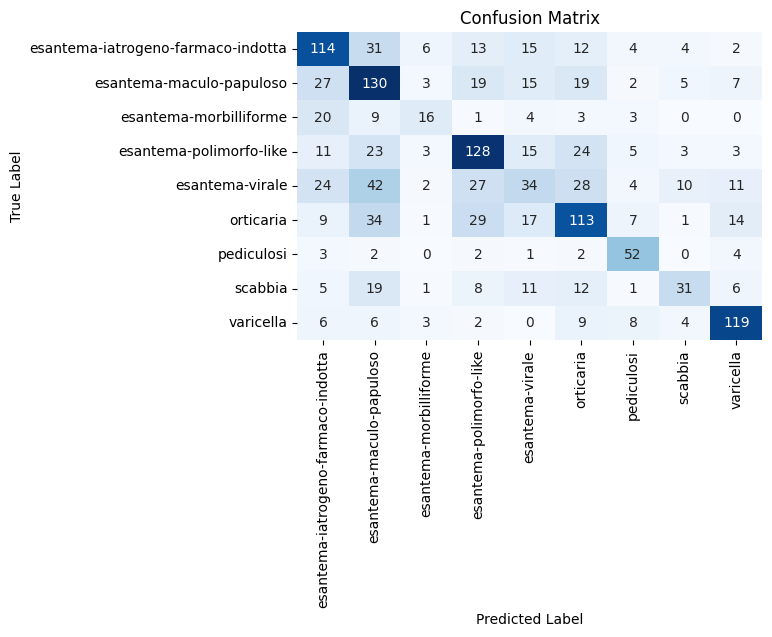

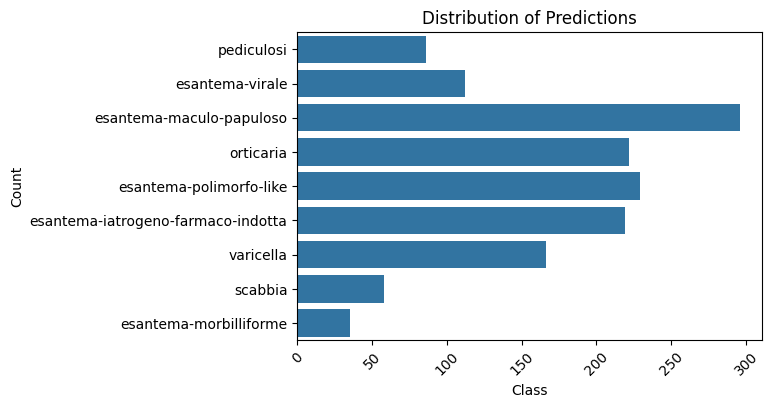

In [115]:
test_model(model,test_loader_mix,device)

### test on dark dataset

100%|██████████| 12/12 [00:12<00:00,  1.06s/it]

Test Accuracy: 0.5266
F1-score: 0.5065
Recall: 0.5111
                                    precision    recall  f1-score   support

esantema-iatrogeno-farmaco-indotta       0.46      0.48      0.47       101
          esantema-maculo-papuloso       0.47      0.62      0.54       114
            esantema-morbilliforme       0.42      0.18      0.25        28
           esantema-polimorfo-like       0.55      0.70      0.62       108
                   esantema-virale       0.34      0.22      0.27        91
                         orticaria       0.54      0.46      0.49       112
                        pediculosi       0.68      0.82      0.75        34
                           scabbia       0.53      0.36      0.43        47
                         varicella       0.75      0.76      0.75        79

                          accuracy                           0.53       714
                         macro avg       0.53      0.51      0.51       714
                      weighted a

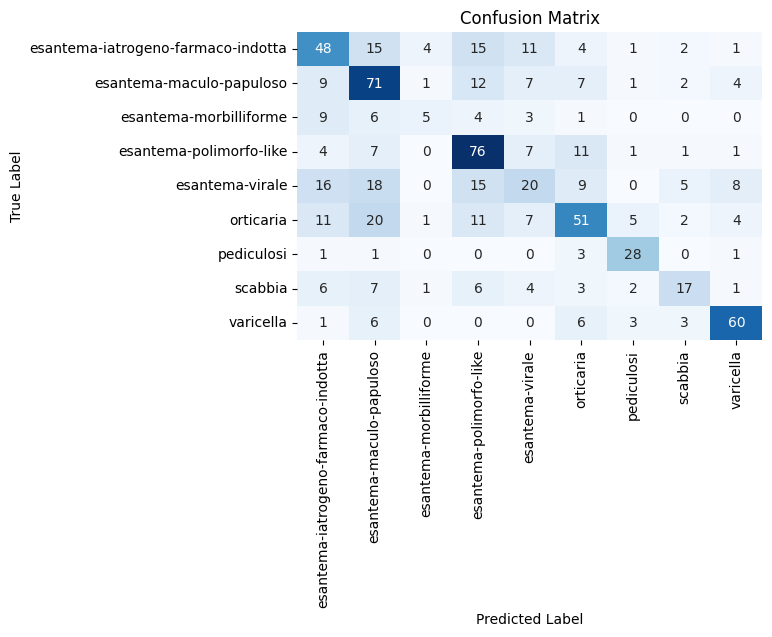

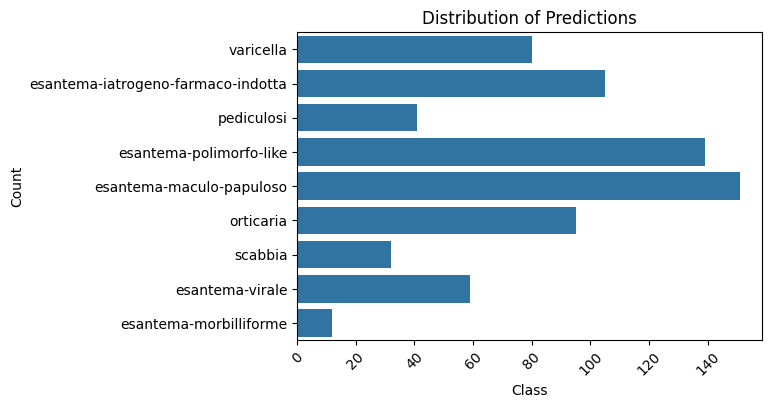

In [116]:
test_model(model,test_loader_dark,device)


### test on white dataset

100%|██████████| 12/12 [00:37<00:00,  3.14s/it]

Test Accuracy: 0.5714
F1-score: 0.5481
Recall: 0.5524
                                    precision    recall  f1-score   support

esantema-iatrogeno-farmaco-indotta       0.64      0.55      0.60       101
          esantema-maculo-papuloso       0.49      0.61      0.54       114
            esantema-morbilliforme       0.47      0.25      0.33        28
           esantema-polimorfo-like       0.72      0.76      0.74       108
                   esantema-virale       0.29      0.26      0.28        91
                         orticaria       0.52      0.54      0.53       112
                        pediculosi       0.70      0.88      0.78        34
                           scabbia       0.54      0.28      0.37        47
                         varicella       0.73      0.84      0.78        79

                          accuracy                           0.57       714
                         macro avg       0.57      0.55      0.55       714
                      weighted a

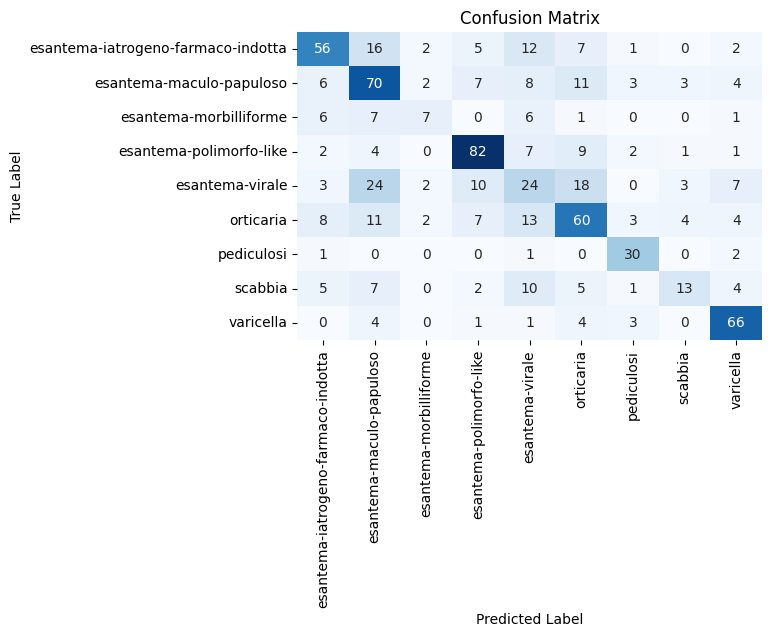

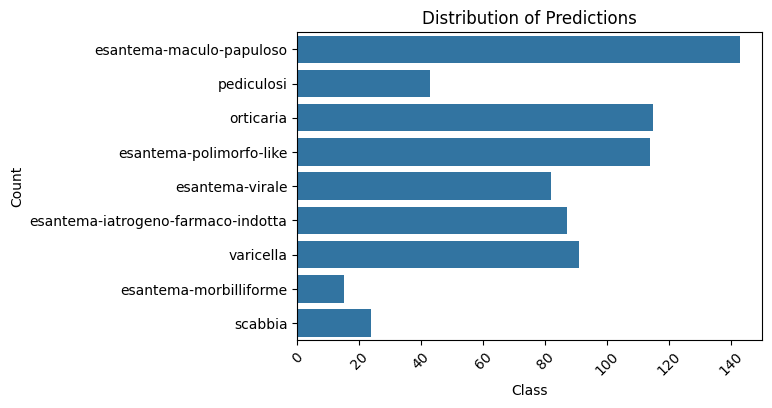

In [117]:
test_model(model,test_loader_original,device)



### Test the model trained on Dark

In [20]:
model2.load_state_dict(torch.load('weights_dark.pth')) 
model2=model2.to(device)

100%|██████████| 23/23 [01:21<00:00,  3.56s/it]

Test Accuracy: 0.4561
F1-score: 0.4196
Recall: 0.4297
                                    precision    recall  f1-score   support

esantema-iatrogeno-farmaco-indotta       0.49      0.46      0.48       201
          esantema-maculo-papuloso       0.43      0.50      0.46       227
            esantema-morbilliforme       0.40      0.14      0.21        56
           esantema-polimorfo-like       0.52      0.53      0.52       215
                   esantema-virale       0.24      0.19      0.21       182
                         orticaria       0.41      0.56      0.48       225
                        pediculosi       0.56      0.73      0.64        66
                           scabbia       0.32      0.10      0.15        94
                         varicella       0.61      0.67      0.64       157

                          accuracy                           0.46      1423
                         macro avg       0.44      0.43      0.42      1423
                      weighted a

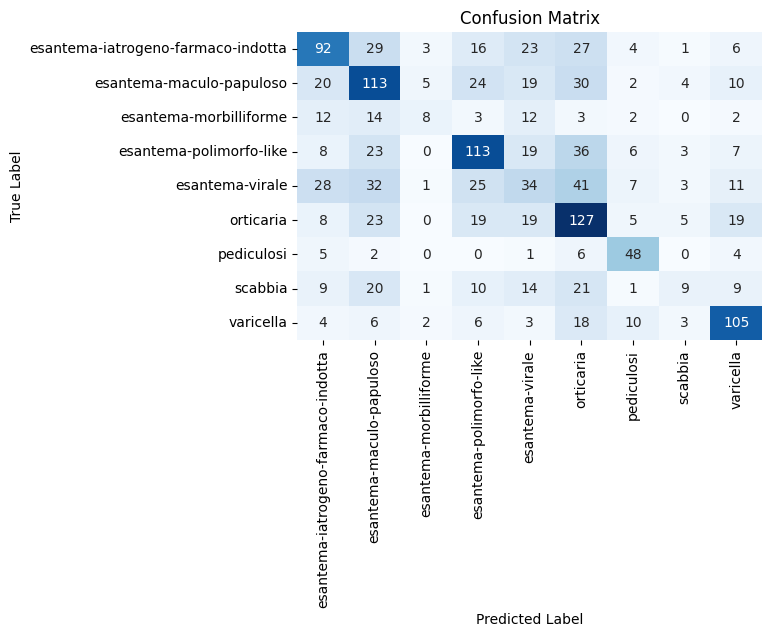

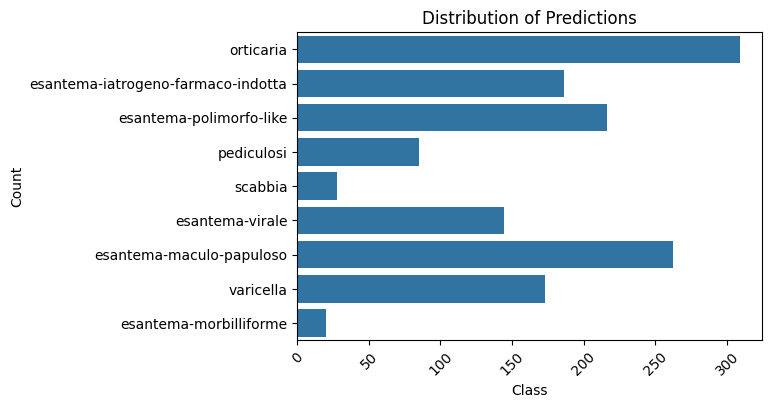

In [108]:
test_model(model2,test_loader_mix,device)

100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Test Accuracy: 0.4314
F1-score: 0.4032
Recall: 0.4043
                                    precision    recall  f1-score   support

esantema-iatrogeno-farmaco-indotta       0.43      0.42      0.42       101
          esantema-maculo-papuloso       0.33      0.45      0.38       114
            esantema-morbilliforme       0.25      0.04      0.06        28
           esantema-polimorfo-like       0.47      0.58      0.52       108
                   esantema-virale       0.25      0.19      0.22        91
                         orticaria       0.43      0.47      0.45       112
                        pediculosi       0.75      0.71      0.73        34
                           scabbia       0.38      0.17      0.24        47
                         varicella       0.60      0.62      0.61        79

                          accuracy                           0.43       714
                         macro avg       0.43      0.40      0.40       714
                      weighted a

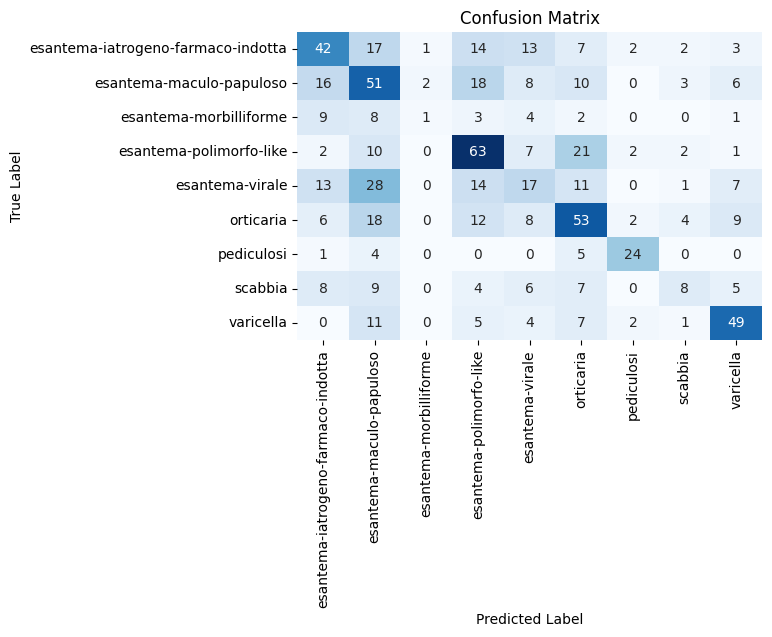

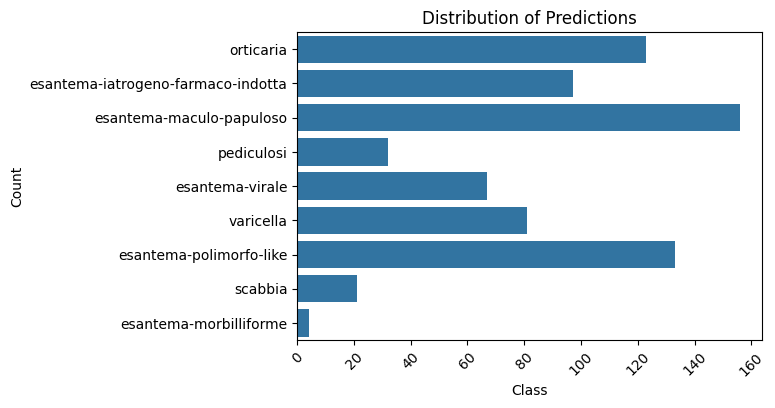

In [109]:
test_model(model2,test_loader_dark,device)

100%|██████████| 12/12 [00:32<00:00,  2.71s/it]

Test Accuracy: 0.4356
F1-score: 0.4139
Recall: 0.4143
                                    precision    recall  f1-score   support

esantema-iatrogeno-farmaco-indotta       0.49      0.36      0.41       101
          esantema-maculo-papuloso       0.43      0.42      0.43       114
            esantema-morbilliforme       0.40      0.14      0.21        28
           esantema-polimorfo-like       0.64      0.51      0.57       108
                   esantema-virale       0.24      0.24      0.24        91
                         orticaria       0.34      0.61      0.44       112
                        pediculosi       0.57      0.71      0.63        34
                           scabbia       0.50      0.15      0.23        47
                         varicella       0.55      0.59      0.57        79

                          accuracy                           0.44       714
                         macro avg       0.46      0.41      0.41       714
                      weighted a

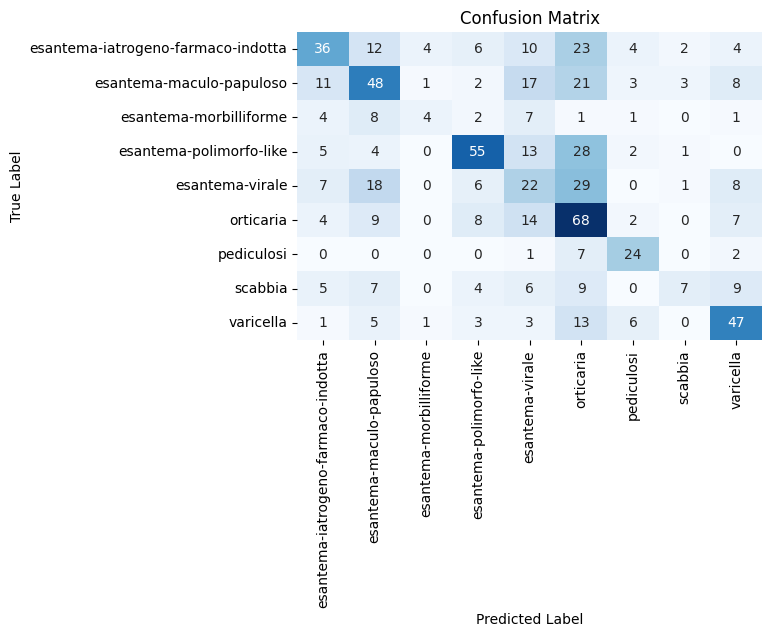

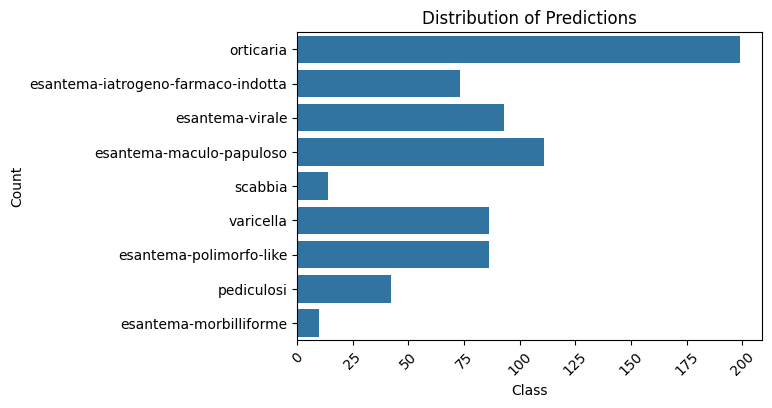

In [110]:
test_model(model2,test_loader_original,device)

### Test the model trained on unbalanced

In [ ]:
model3.load_state_dict(torch.load('unbalanced_augmentation.pth')) 
model3=model3.to(device)

100%|██████████| 12/12 [00:12<00:00,  1.07s/it]

Test Accuracy: 0.4762
F1-score: 0.4661
Recall: 0.4580
                                    precision    recall  f1-score   support

esantema-iatrogeno-farmaco-indotta       0.52      0.47      0.49       101
          esantema-maculo-papuloso       0.37      0.54      0.44       114
            esantema-morbilliforme       0.62      0.18      0.28        28
           esantema-polimorfo-like       0.50      0.63      0.56       108
                   esantema-virale       0.27      0.21      0.23        91
                         orticaria       0.49      0.46      0.47       112
                        pediculosi       0.76      0.74      0.75        34
                           scabbia       0.39      0.26      0.31        47
                         varicella       0.68      0.66      0.67        79

                          accuracy                           0.48       714
                         macro avg       0.51      0.46      0.47       714
                      weighted a

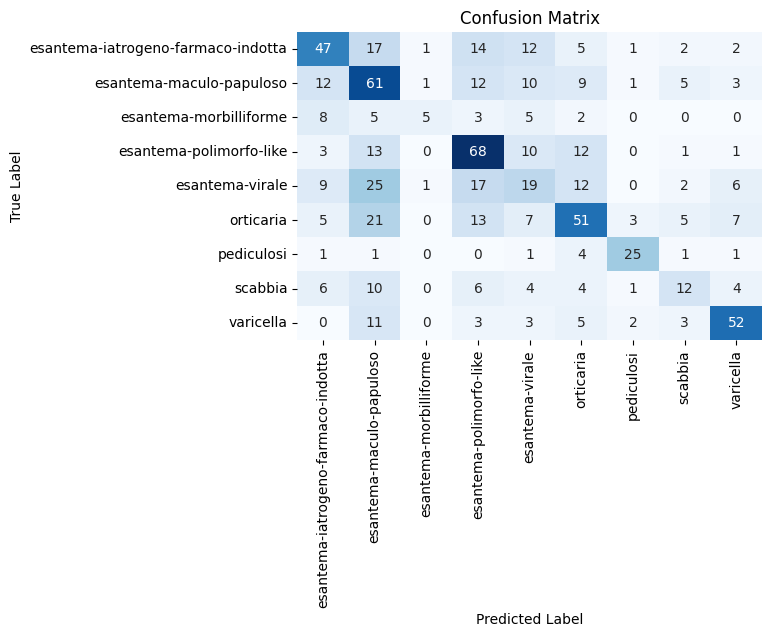

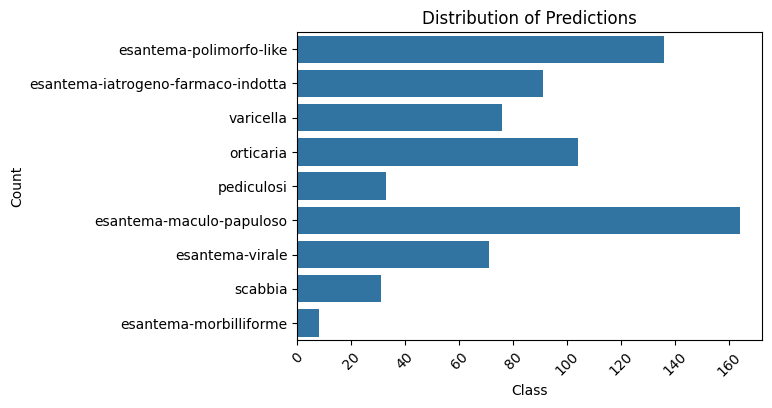

In [ ]:
test_model(model3,test_loader_dark,device)

100%|██████████| 12/12 [00:33<00:00,  2.83s/it]

Test Accuracy: 0.5014
F1-score: 0.4807
Recall: 0.4795
                                    precision    recall  f1-score   support

esantema-iatrogeno-farmaco-indotta       0.57      0.51      0.54       101
          esantema-maculo-papuloso       0.42      0.44      0.43       114
            esantema-morbilliforme       0.27      0.14      0.19        28
           esantema-polimorfo-like       0.65      0.69      0.67       108
                   esantema-virale       0.29      0.31      0.30        91
                         orticaria       0.42      0.54      0.47       112
                        pediculosi       0.81      0.85      0.83        34
                           scabbia       0.36      0.17      0.23        47
                         varicella       0.68      0.66      0.67        79

                          accuracy                           0.50       714
                         macro avg       0.50      0.48      0.48       714
                      weighted a

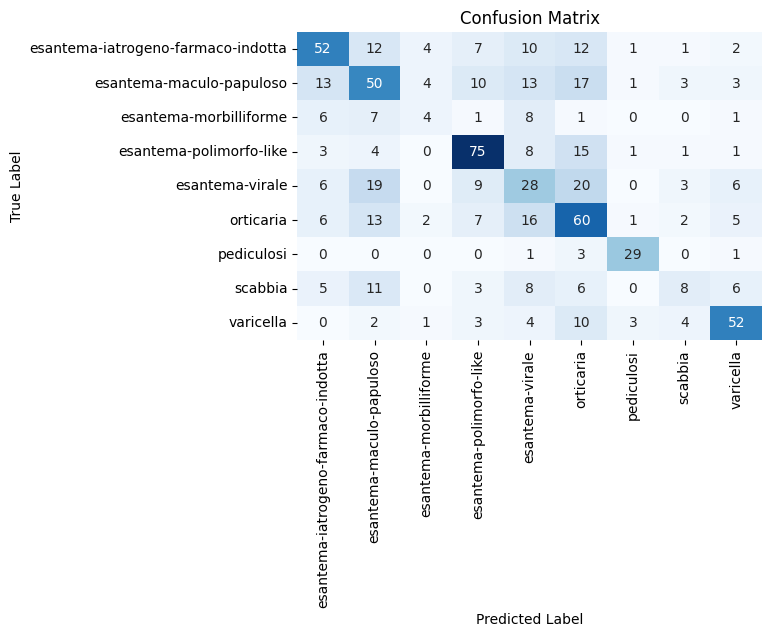

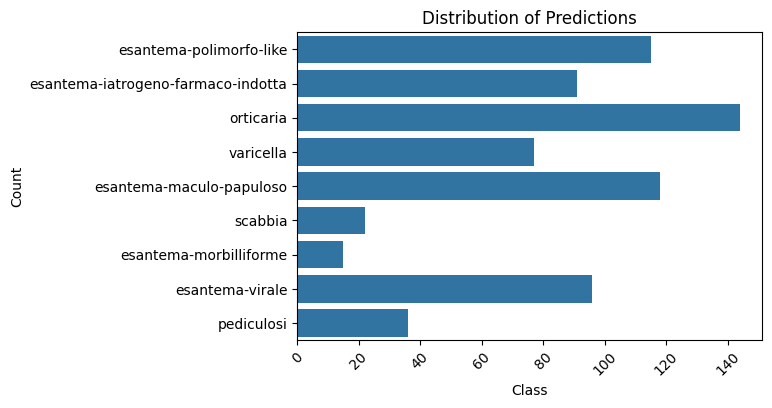

In [ ]:
test_model(model3,test_loader_original,device)